In [1]:
!git clone https://github.com/S-aiueo32/lpips-pytorch.git
!git clone https://github.com/Jeferson0809/LPIPS
!mv lpips-pytorch/lpips_pytorch /content/

Cloning into 'lpips-pytorch'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 107 (delta 46), reused 73 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 576.88 KiB | 2.26 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Cloning into 'LPIPS'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 131.57 KiB | 364.00 KiB/s, done.
Resolving deltas: 100% (1/1), done.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:00<00:00, 315MB/s]


Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


100%|██████████| 5.87k/5.87k [00:00<00:00, 6.15MB/s]


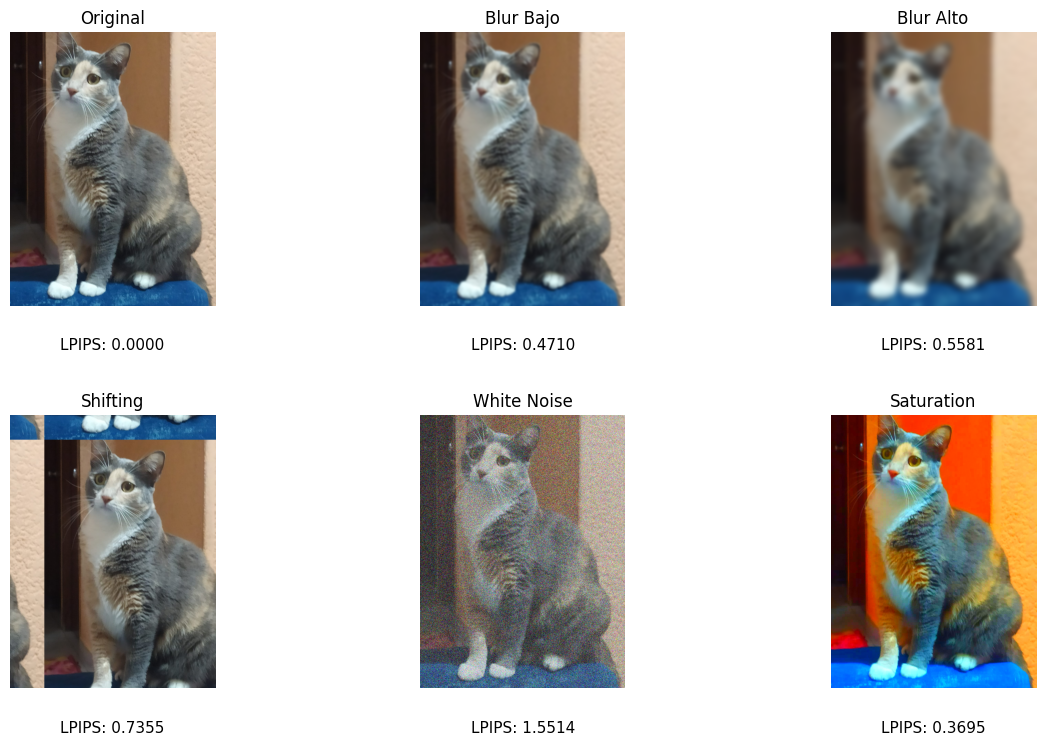

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from pathlib import Path
from PIL import Image, ImageFilter, ImageChops, ImageEnhance
from lpips_pytorch import lpips
import numpy as np

def to_tensor(image):
    return TF.to_tensor(image).unsqueeze(0) * 2 - 1

# Cargar original
img_path = Path("/content/LPIPS/gato.jpeg")
img = Image.open(img_path).convert("RGB")

# Distorsiones (ejemplo)
img_blur_low = img.filter(ImageFilter.GaussianBlur(radius=5))
img_blur_high = img.filter(ImageFilter.GaussianBlur(radius=15))
img_shift = ImageChops.offset(img, xoffset=200, yoffset=150)

# Ruido más fuerte
np_img = np.array(img).astype(np.float32) / 255.0
noise = np.random.normal(0, 0.5, np_img.shape)
np_noisy = np.clip(np_img + noise, 0, 1) * 255
img_noise = Image.fromarray(np_noisy.astype(np.uint8))

# Saturación
enhancer = ImageEnhance.Color(img)
img_saturation = enhancer.enhance(5)

# Tensores
tensor_org = to_tensor(img)
tensor_blur_low = to_tensor(img_blur_low)
tensor_blur_high = to_tensor(img_blur_high)
tensor_shift = to_tensor(img_shift)
tensor_noise = to_tensor(img_noise)
tensor_saturation = to_tensor(img_saturation)

# Calcular LPIPS (como float)
loss = lambda a,b: lpips(a, b, net_type='alex', version='0.1').item()
score_org = loss(tensor_org, tensor_org)  # debe ser ~0
scores = {
    "Original": score_org,
    "Blur Bajo": loss(tensor_org, tensor_blur_low),
    "Blur Alto": loss(tensor_org, tensor_blur_high),
    "Shifting": loss(tensor_org, tensor_shift),
    "White Noise": loss(tensor_org, tensor_noise),
    "Saturation": loss(tensor_org, tensor_saturation),
}

# Pares imagen+score en el orden deseado
imagenes = [
    ("Original", img, scores["Original"]),
    ("Blur Bajo", img_blur_low, scores["Blur Bajo"]),
    ("Blur Alto", img_blur_high, scores["Blur Alto"]),
    ("Shifting", img_shift, scores["Shifting"]),
    ("White Noise", img_noise, scores["White Noise"]),
    ("Saturation", img_saturation, scores["Saturation"]),
]

# Plot: cada imagen con su LPIPS debajo
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, (nombre, imagen, score) in zip(axes, imagenes):
    ax.imshow(imagen)
    ax.set_title(nombre)
    ax.axis("off")
    # colocamos el texto debajo de la imagen usando coordenadas relativas al axes
    ax.text(0.5, -0.12, f"LPIPS: {score:.4f}", transform=ax.transAxes,
            ha='center', va='top', fontsize=11)

# Ajustes para que haya espacio para el texto
plt.subplots_adjust(hspace=0.4, bottom=0.06)
plt.show()
